In [98]:
from glob import iglob
import os

import pandas as pd
import screed
import seaborn as sns
import tqdm

In [2]:
cd ~/data_sm/kmer-hashing/quest-for-orthologs/analysis/2019/

/mnt/data_sm/olga/kmer-hashing/quest-for-orthologs/analysis/2019


In [3]:
ls -lha

total 6.3M
drwxr-xr-x 3 olga czb 4.0K Jan  8 07:43 ./
drwxr-xr-x 3 olga czb 4.0K Dec 25 19:12 ../
-rw-r--r-- 1 olga czb 6.2M Sep  6  2018 GO.83ebff415cfec35b9ae1888e.tsv.gz
drwxr-xr-x 2 olga czb 128K Jan  8 07:42 intermediates/


# Download orthology and transcription factor data

## Download OMA GETHOGs benchmark results

This had the most number of ortholog pairs of all the services submitted to the [Quest for Orthologs' benchmarking service - Gene Ontology Conservation test](https://orthology.benchmarkservice.org/cgi-bin/gateway.pl?f=CheckResults&p1=10f28e6c09fd6acc1a90ade6)

In [4]:
# ! wget https://orthology.benchmarkservice.org/raw//GO/GO.83ebff415cfec35b9ae1888e.tsv.gz
# ! zcat GO.83ebff415cfec35b9ae1888e.tsv.gz | head

In [5]:
oma = pd.read_csv('GO.83ebff415cfec35b9ae1888e.tsv.gz', sep='\t', skiprows=2, header=None)
oma.columns = ['protein_id1', 'protein_id2', 'go_similarity']
print(oma.shape)
oma.head()

(927900, 3)


,protein_id1,protein_id2,go_similarity
0,Q5JCX3,P07650,0.373544
1,Q5JCX3,P19971,0.467737
2,Q5JDA9,O67379,1.000000
3,Q5JF32,Q9DEA3,0.460952
4,Q5JF32,P17918,0.575735


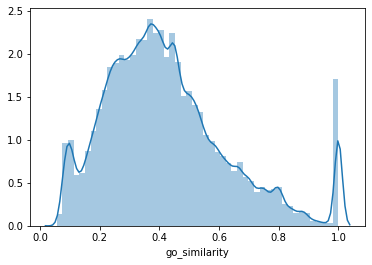

In [6]:
sns.distplot(oma.go_similarity)

## Read transcription factors 

In [7]:
tf_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_human_transcription_factors')[0]
print(tf_df.shape)
tf_df.head()

(1639, 5)


,Gene,ID,DBD,Motif status (Feb 2018)(Link to human TFs annotation),IUPAC consensus (from selected PWM)
0,AC008770.3,ENSG00000267179,C2H2 ZF,Likely sequence specific TF according to liter...,NaN
1,AC023509.3,ENSG00000267281,bZIP,Known motif – from protein with 100% identical...,RTGACGTCAY
2,AC092835.1,ENSG00000233757,C2H2 ZF,Likely sequence specific TF according to liter...,NaN
3,AC138696.1,ENSG00000264668,C2H2 ZF,Known motif – from protein with 100% identical...,RYGGAGAGTTAGC
4,ADNP,ENSG00000101126,Homeodomain,Likely sequence specific TF according to liter...,NaN


# Go to Quest for Orthologs fastas

In [8]:
cd /home/olga/data_sm/kmer-hashing/quest-for-orthologs/data/2019

/mnt/data_sm/olga/kmer-hashing/quest-for-orthologs/data/2019


In [9]:
ls -lha

total 2.6G
drwxr-xr-x 5 olga root 4.0K Jan  7 11:13 ./
drwxr-xr-x 3 olga root 4.0K Dec 25 17:48 ../
drwxr-xr-x 5 olga czb  4.0K Dec 26 19:44 Archaea/
drwxr-xr-x 5 olga czb   16K Dec 26 19:44 Bacteria/
drwxr-xr-x 6 olga czb   32K Dec 26 19:49 Eukaryota/
-rw-r--r-- 1 olga czb  2.6G Dec 25 18:46 QfO_release_2019_04.tar.gz
-rw-r--r-- 1 olga czb   18K May 10  2019 README
-rw-r--r-- 1 olga czb   12K Jan  7 11:13 species_metadata.csv


## Read species metadata

In [11]:
species_metadata = pd.read_csv("species_metadata.csv")
print(species_metadata.shape)
species_metadata.head()

(78, 10)


,proteome_id,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain
0,UP000007062,7165,ANOGA,12553,971,13619,Anopheles gambiae (African malaria mosquito),797.0,Anopheles gambiae,African malaria mosquito
1,UP000000798,224324,AQUAE,1553,0,1557,Aquifex aeolicus (strain VF5),4290.0,Aquifex aeolicus,strain VF5
2,UP000006548,3702,ARATH,27475,14123,41920,Arabidopsis thaliana (Mouse-ear cress),1496.0,Arabidopsis thaliana,Mouse-ear cress
3,UP000001570,224308,BACSU,4260,7,4268,Bacillus subtilis (strain 168),4290.0,Bacillus subtilis,strain 168
4,UP000001414,226186,BACTN,4782,0,4823,Bacteroides thetaiotaomicron (strain ATCC 2914...,4290.0,Bacteroides thetaiotaomicron,strain ATCC 29148 / DSM 2079 / NCTC 10582 / E5...


### Subset to opisthokonts

In [121]:
# Estimated opisthokonta divergence time from http://timetree.org/
t = 1105
opisthokonts = species_metadata.query('divergence_from_human_mya <= @t')
print(opisthokonts.shape)
opisthokonts.head()

(35, 10)


,proteome_id,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain
0,UP000007062,7165,ANOGA,12553,971,13619,Anopheles gambiae (African malaria mosquito),797.0,Anopheles gambiae,African malaria mosquito
5,UP000007241,684364,BATDJ,8610,0,8685,Batrachochytrium dendrobatidis (strain JAM81 /...,1105.0,Batrachochytrium dendrobatidis,strain JAM81 / FGSC 10211
6,UP000009136,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine
8,UP000001554,7739,BRAFL,28542,2,28608,Branchiostoma floridae (Florida lancelet) (Amp...,684.0,Branchiostoma floridae,Florida lancelet
9,UP000001940,6239,CAEEL,19986,8309,28507,Caenorhabditis elegans,797.0,Caenorhabditis elegans,NaN


In [122]:
opisthokonts.query('scientific_name == "Homo sapiens"')

,proteome_id,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain
32,UP000005640,9606,HUMAN,21146,74769,96332,Homo sapiens (Human),0.0,Homo sapiens,Human


## Subset human proteins to TFs

In [13]:
human_proteome_id = 'UP000005640'

In [14]:
ll Eukaryota/human-protein-fastas/

total 1
lrwxrwxrwx 1 olga 104 Dec 26 19:44 UP000005640_9606_additional.fasta -> /mnt/data_sm/olga/kmer-hashing/quest-for-orthologs/data/2019/Eukaryota/UP000005640_9606_additional.fasta
lrwxrwxrwx 1 olga  93 Dec 26 19:44 UP000005640_9606.fasta -> /mnt/data_sm/olga/kmer-hashing/quest-for-orthologs/data/2019/Eukaryota/UP000005640_9606.fasta


In [18]:
!head Eukaryota/human-protein-fastas/*

==> Eukaryota/human-protein-fastas/UP000005640_9606.fasta <==
>tr|A0A024R1R8|A0A024R1R8_HUMAN HCG2014768, isoform CRA_a OS=Homo sapiens OX=9606 GN=hCG_2014768 PE=4 SV=1
MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAKVVGKGPLATGGIKK
SGKK
>sp|A0A024RBG1|NUD4B_HUMAN Diphosphoinositol polyphosphate phosphohydrolase NUDT4B OS=Homo sapiens OX=9606 GN=NUDT4B PE=3 SV=1
MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQWIVPGGGMEPEEEPG
GAAVREVYEEAGVKGKLGRLLGIFEQNQDRKHRTYVYVLTVTEILEDWEDSVNIGRKREW
FKVEDAIKVLQCHKPVHAEYLEKLKLGCSPANGNSTVPSLPDNNALFVTAAQTSGLPSSV
R
>tr|A0A075B6H5|A0A075B6H5_HUMAN T cell receptor beta variable 20/OR9-2 (non-functional) (Fragment) OS=Homo sapiens OX=9606 GN=TRBV20OR9-2 PE=4 SV=1
METVVTTLPREGGVGPSRKMLLLLLLLGPGSGLSAVVSQHPSRVICKSGTSVNIECRSLD

==> Eukaryota/human-protein-fastas/UP000005640_9606_additional.fasta <==
>tr|A0A024QYW1|A0A024QYW1_HUMAN Isoform of A6NGB0, Transmembrane protein 191C OS=Homo sapiens OX=9606 GN=TMEM191C PE=4 SV=1
MVNNTDFLMLNNLWNKLCLVSMDFCFPLDFVSNVFWIFASKFIIVT

In [24]:
ll Eukaryota/UP000005640*

-rw-r--r-- 1 olga   36918952 Apr 12  2019 Eukaryota/UP000005640_9606_additional.fasta
-rw-r--r-- 1 olga   34929850 Apr 13  2019 Eukaryota/UP000005640_9606_DNA.fasta
-rw-r--r-- 1 olga      20163 Apr 13  2019 Eukaryota/UP000005640_9606_DNA.miss
-rw-r--r-- 1 olga   13737946 Apr 12  2019 Eukaryota/UP000005640_9606.fasta
-rw-r--r-- 1 olga      50862 May  6  2019 Eukaryota/UP000005640_9606_gcoord.miss
-rw-r--r-- 1 olga 1010405266 May  6  2019 Eukaryota/UP000005640_9606_gcoord.xml
-rw-r--r-- 1 olga    2805864 Apr 12  2019 Eukaryota/UP000005640_9606.gene2acc
-rw-r--r-- 1 olga   69939964 May  3  2019 Eukaryota/UP000005640_9606.idmapping
-rw-r--r-- 1 olga  122397065 May 10  2019 Eukaryota/UP000005640_9606.xml


In [31]:
!grep 'ENSG00000267179' Eukaryota/UP000005640*

Eukaryota/UP000005640_9606.gene2acc:ENSG00000267179	F5H0A9	ENSG00000267179
Eukaryota/UP000005640_9606.gene2acc:ENSG00000267179	K7EJH5	ENSG00000267179
Eukaryota/UP000005640_9606.gene2acc:ENSG00000267179	K7EPL6	ENSG00000267179
Eukaryota/UP000005640_9606.idmapping:K7EJH5	BioMuta	ENSG00000267179
Eukaryota/UP000005640_9606.idmapping:K7EJH5	Ensembl	ENSG00000267179
Eukaryota/UP000005640_9606.idmapping:K7EJH5	GeneCards	ENSG00000267179
Eukaryota/UP000005640_9606.idmapping:K7EPL6	BioMuta	ENSG00000267179
Eukaryota/UP000005640_9606.idmapping:K7EPL6	Ensembl	ENSG00000267179
Eukaryota/UP000005640_9606.idmapping:K7EPL6	GeneCards	ENSG00000267179
Eukaryota/UP000005640_9606.idmapping:F5H0A9	BioMuta	ENSG00000267179
Eukaryota/UP000005640_9606.idmapping:F5H0A9	Ensembl	ENSG00000267179
Eukaryota/UP000005640_9606.idmapping:F5H0A9	GeneCards	ENSG00000267179
Eukaryota/UP000005640_9606_gcoord.xml:    <gnCoordinate ensembl_gene_id="ENSG00000267179" ensembl_transcript_id="ENST00000591944" ensembl_translation_id="ENS

## Read Gene Accession file

```
Gene mapping files (*.gene2acc)
===============================

Column 1 is a unique gene symbol that is chosen with the following order of
preference from the annotation found in:
1) Model Organism Database (MOD)
2) Ensembl or Ensembl Genomes database
3) UniProt Ordered Locus Name (OLN)
4) UniProt Open Reading Frame (ORF)
5) UniProt Gene Name
A dash symbol ('-') is used when the gene encoding a protein is unknown.

Column 2 is the UniProtKB accession or isoform identifier for the given gene
symbol. This column may have redundancy when two or more genes have identical
translations.

Column 3 is the gene symbol of the canonical accession used to represent the
respective gene group and the first row of the sequence is the canonical one.
```

In [109]:

def read_gene2acc(gene2acc, names=['maybe_ensembl_id', 'uniprot_id', 'canonical_accession']):
    df = pd.read_csv(gene2acc, sep='\t', header=None, na_values='-', names=columns)
    return df

gene2acc = read_gene2acc('Eukaryota/UP000005640_9606.gene2acc')
# gene2acc = pd.read_csv('Eukaryota/UP000005640_9606.gene2acc', sep='\t', header=None, na_values='-', names=columns)
print(gene2acc.shape)
gene2acc.head()

(96332, 3)


,maybe_ensembl_id,uniprot_id,canonical_accession
0,NaN,A0A075B7B6,NaN
1,NaN,A0A075B714,NaN
2,NaN,A0A075B713,NaN
3,NaN,A0A075B712,NaN
4,NaN,A0A075B711,NaN


In [29]:
gene2acc.dropna()

,maybe_ensembl_id,uniprot_id,canonical_accession
600,ACOT7L,Q6ZUV0,ACOT7L
601,BARGIN,Q6ZT62,BARGIN
602,BARGIN,Q6ZT62-2,BARGIN
603,BCE1,O60756,BCE1
604,C1orf140,Q5VVS0,C1orf140
...,...,...,...
96327,UNQ6190/PRO20217,Q6UXQ8,UNQ6190/PRO20217
96328,UNQ6493/PRO21345,Q6UXR8,UNQ6493/PRO21345
96329,UNQ6494/PRO21346,Q6UXR6,UNQ6494/PRO21346
96330,UNQ9165/PRO28630,Q6UXU0,UNQ9165/PRO28630


## Read ID mapping file

```
Database mapping files (*.idmapping)
====================================

These files contain mappings from UniProtKB to other databases for each
reference proteome.
The format consists of three tab-separated columns:

1. UniProtKB accession
2. ID_type:
   Database name as shown in UniProtKB cross-references and supported by the ID
   mapping tool on the UniProt web site (http://www.uniprot.org/mapping)
3. ID:
   Identifier in the cross-referenced database.

```

In [34]:
id_mapping = pd.read_csv('Eukaryota/UP000005640_9606.idmapping', sep='\t', header=None, names=['uniprot_id', 'id_type', 'db_id'])
print(id_mapping.shape)
id_mapping.head()

(2668934, 3)


,uniprot_id,id_type,db_id
0,P62258-2,UniParc,UPI00001E6021
1,P62258-2,Ensembl_TRS,ENST00000571732
2,P62258-2,Ensembl_PRO,ENSP00000461762
3,P62258-2,Ensembl_TRS,ENST00000616643
4,P62258-2,Ensembl_PRO,ENSP00000481059


In [36]:
id_mapping.id_type.value_counts()

EMBL          273867
GI            270441
EMBL-CDS      198723
eggNOG        110646
UniParc        95965
               ...  
Allergome         77
PeroxiBase        33
REBASE             5
GeneDB             2
PATRIC             1
Name: id_type, Length: 68, dtype: int64

In [44]:
id_mapping.id_type.nunique()

68

### Get ENSEMBL id mapping

In [40]:
ensembl_mapping = id_mapping.query('id_type == "Ensembl"')
print(ensembl_mapping.shape)
ensembl_mapping.head()

(78145, 3)


,uniprot_id,id_type,db_id
80,P61981,Ensembl,ENSG00000170027
178,P27348,Ensembl,ENSG00000134308
279,P30443,Ensembl,ENSG00000229215
282,P30443,Ensembl,ENSG00000224320
342,Q96QU6,Ensembl,ENSG00000110455


### Get ENSEMBL TF ID mapping

In [42]:
ensembl_mapping_tfs = ensembl_mapping.query('db_id in @tf_df.ID')
print(ensembl_mapping_tfs.shape)
ensembl_mapping_tfs.head()

(5753, 3)


,uniprot_id,id_type,db_id
11056,Q6IQ32,Ensembl,ENSG00000101544
13379,P35869,Ensembl,ENSG00000106546
13744,O43918,Ensembl,ENSG00000160224
16547,O95076,Ensembl,ENSG00000156150
24705,Q14865,Ensembl,ENSG00000150347


In [77]:
tf_df_uniprot = tf_df.merge(ensembl_mapping, left_on='ID', right_on='db_id')
print(tf_df_uniprot.shape)
tf_df_uniprot.head()

(5753, 8)


,Gene,ID,DBD,Motif status (Feb 2018)(Link to human TFs annotation),IUPAC consensus (from selected PWM),uniprot_id,id_type,db_id
0,AC008770.3,ENSG00000267179,C2H2 ZF,Likely sequence specific TF according to liter...,NaN,K7EJH5,Ensembl,ENSG00000267179
1,AC008770.3,ENSG00000267179,C2H2 ZF,Likely sequence specific TF according to liter...,NaN,K7EPL6,Ensembl,ENSG00000267179
2,AC008770.3,ENSG00000267179,C2H2 ZF,Likely sequence specific TF according to liter...,NaN,F5H0A9,Ensembl,ENSG00000267179
3,AC023509.3,ENSG00000267281,bZIP,Known motif – from protein with 100% identical...,RTGACGTCAY,K7ELQ4,Ensembl,ENSG00000267281
4,AC092835.1,ENSG00000233757,C2H2 ZF,Likely sequence specific TF according to liter...,NaN,A0A087WUV0,Ensembl,ENSG00000233757


In [56]:
ensembl_mapping_tfs.uniprot_id.nunique()

5749

In [43]:
ensembl_mapping_tfs.db_id.nunique()

1633

In [ ]:
ensembl_protein = id_mapping.query('')

In [20]:
# !grep ENSG Eukaryota/human-protein-fastas/* 

In [15]:
human_outdir = 'Eukaryota/human-transcription-factor-fastas/'
! mkdir $human_outdir

# Read human proteins and subset to human tfs

In [57]:
tf_records = []


for filename in iglob('Eukaryota/human-protein-fastas/*.fasta'):
    with screed.open(filename) as records:
        for record in records:
            name = record['name']
            record_id = name.split()[0]
            uniprot_id = record_id.split('|')[1]
            if uniprot_id in ensembl_mapping_tfs.uniprot_id.values:
                tf_records.append(record)
print(len(tf_records))


In [58]:
tf_records[:3]

[{'name': 'tr|A0A087WUV0|A0A087WUV0_HUMAN Uncharacterized protein OS=Homo sapiens OX=9606 PE=1 SV=1', 'sequence': 'MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEALTQWRQLNSPQGDVPEKPRNLVLLGLPISTPDVISQLEHEEELEREVSKAASQKHWETIPESKELTPEKDISEEESAPGVLIVRFSKESSSECEDSLESQQENHEKHLIQEAVTEKSSRERSYQSDEFRRNCTQRSLLVQQQGERLHHCDSFKNNLKQNSDIIRHERICAGKKPWKCNECEKAFSYYSAFVLHQRIHTGEKPYECNECGKAFSQSIHLTLHQRIHTGEKPYECHECGKAFSHRSALIRHHIIHTGEKPYECNECGKAFNQSSYLTQHQRIHTGEKPYECNECGKAFSQSTFLTQHQVIHTGEKPYKCNECGKAFSDRSGLIQHQRTHTGERPYECNECGKAFGYCSALTQHQRTHTGEKPYKCNDCAKAFSDRSALIRHQRTHTGEKPYKCKDCGKAFSQSSSLTKHQKTHTGEKPYKCKECGKAFSQSSSLSQHQKTHAGVKTKKYVQALSEHLTFGQHKRIHTG', 'description': ''},
 {'name': 'sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8 OS=Homo sapiens OX=9606 GN=E2F8 PE=1 SV=1', 'sequence': 'MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPTKPKEGSQGEPWTPTANLKMLISAVSPEIRNRDQKRGLFDNRSGLPEAKDCIHEHLSGDEFEKSQPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAEELNVERRRIYDIVNVLESLHMVSRLAKNRYTWHGRHNLNKTLGTLKSIGEENKYAEQIMMIKKKEYEQEFDFIKSYS

## Write output

In [61]:

with open(f'{human_outdir}/human_transcription_factor_proteins.fasta', 'w') as f:
    for record in tf_records:
        f.write(">{name}\n{sequence}\n".format(**record))

# Read non-human proteins and subset if they are an ortholog of a TF

## Make outdir

In [100]:
not_human_outdir = 'Eukaryota/not-human-transcription-factor-fastas/'
! mkdir $not_human_outdir


mkdir: cannot create directory ‘Eukaryota/not-human-transcription-factor-fastas/’: File exists


## Subset OMA to only orthologs of ensembl tfs

In [65]:
print(oma.shape)
oma.head()

(927900, 3)


,protein_id1,protein_id2,go_similarity
0,Q5JCX3,P07650,0.373544
1,Q5JCX3,P19971,0.467737
2,Q5JDA9,O67379,1.000000
3,Q5JF32,Q9DEA3,0.460952
4,Q5JF32,P17918,0.575735


## is OMA reciprocal? -- YES!

In [79]:
oma.query('protein_id2 == "P07650" & protein_id1 == "Q5JCX3"')

,protein_id1,protein_id2,go_similarity
0,Q5JCX3,P07650,0.373544


In [63]:
ensembl_mapping_tfs.head()

,uniprot_id,id_type,db_id
11056,Q6IQ32,Ensembl,ENSG00000101544
13379,P35869,Ensembl,ENSG00000106546
13744,O43918,Ensembl,ENSG00000160224
16547,O95076,Ensembl,ENSG00000156150
24705,Q14865,Ensembl,ENSG00000150347


In [75]:
uniprot_tfs = set(ensembl_mapping_tfs.uniprot_id)
len(uniprot_tfs)

5749

## Add OMA to TF + uniprot dataframe

In [80]:
tfs_uniprot_oma = tf_df_uniprot.merge(oma, left_on='uniprot_id', right_on='protein_id1')
print(tfs_uniprot_oma.shape)
tfs_uniprot_oma.head()

(21350, 11)


,Gene,ID,DBD,Motif status (Feb 2018)(Link to human TFs annotation),IUPAC consensus (from selected PWM),uniprot_id,id_type,db_id,protein_id1,protein_id2,go_similarity
0,ARNT,ENSG00000143437,bHLH,Known motif – from protein with 100% identical...,KCACGTGM,P27540,Ensembl,ENSG00000143437,P27540,Q9BE97,0.621954
1,CDC5L,ENSG00000096401,Myb/SANT,Known motif – In vivo/Misc source [91],VBGWKDTAAYRWAWB,Q99459,Ensembl,ENSG00000096401,Q99459,P92948,0.475321
2,CEBPZ,ENSG00000115816,Unknown,Known motif – In vivo/Misc source [100],DSTSATTGGCT,Q03701,Ensembl,ENSG00000115816,Q03701,F4IDC2,0.103061
3,CRX,ENSG00000105392,Homeodomain,Known motif – High-throughput in vitro [124],TAATCC,O43186,Ensembl,ENSG00000105392,O43186,Q9XSK0,0.622423
4,CXXC4,ENSG00000168772,CxxC,Likely sequence specific TF according to liter...,NaN,Q9H2H0,Ensembl,ENSG00000168772,Q9H2H0,Q0VFP6,0.076427


In [87]:
tfs_uniprot_oma.ID.value_counts()

ENSG00000142528    352
ENSG00000171817    352
ENSG00000170631    352
ENSG00000172273    352
ENSG00000102189    352
                  ... 
ENSG00000127445      1
ENSG00000105392      1
ENSG00000185129      1
ENSG00000170515      1
ENSG00000100644      1
Name: ID, Length: 112, dtype: int64

## Which species are these orthologous TFs in?

In [107]:
ll Eukaryota/*gene2acc | head

-rw-r--r-- 1 olga 2598262 Apr 11  2019 Eukaryota/UP000000437_7955.gene2acc
-rw-r--r-- 1 olga 1300443 Apr 11  2019 Eukaryota/UP000000539_9031.gene2acc
-rw-r--r-- 1 olga  274395 Apr 11  2019 Eukaryota/UP000000542_5664.gene2acc
-rw-r--r-- 1 olga  271989 Apr 11  2019 Eukaryota/UP000000559_237561.gene2acc
-rw-r--r-- 1 olga  221943 Apr 11  2019 Eukaryota/UP000000561_237631.gene2acc
-rw-r--r-- 1 olga 1973957 Apr 11  2019 Eukaryota/UP000000589_10090.gene2acc
-rw-r--r-- 1 olga 1698073 Apr 11  2019 Eukaryota/UP000000600_5888.gene2acc
-rw-r--r-- 1 olga 1113953 Apr 11  2019 Eukaryota/UP000000803_7227.gene2acc
-rw-r--r-- 1 olga 1703916 Apr 11  2019 Eukaryota/UP000001038_8090.gene2acc
-rw-r--r-- 1 olga  464020 Apr 11  2019 Eukaryota/UP000001055_321614.gene2acc


In [108]:
ls -1 Eukaryota/*gene2acc | head -n 3 | xargs head

==> Eukaryota/UP000000437_7955.gene2acc <==
-	A0A0J9YJK1	-
-	A0A0J9YJH4	-
-	A0A0J9YJF6	-
-	A0A0J9YJD3	-
-	A0A0J9YJD0	-
-	A0A0J9YJA9	-
-	A0A0J9YJ97	-
-	A0A0J9YJ90	-
-	A0A0J9YJ89	-
-	A0A0J9YJ87	-

==> Eukaryota/UP000000539_9031.gene2acc <==
-	P12275	-
-	P12264	-
-	P12105	-
-	P11722	-
-	P11682	-
-	P11148	-
-	P10399	-
-	P0C915	-
-	P09987	-
-	P09859	-

==> Eukaryota/UP000000542_5664.gene2acc <==
LMJF_01_0010	E9ABZ0	LMJF_01_0010
LMJF_01_0020	E9ABZ1	LMJF_01_0020
LMJF_01_0030	E9ABZ2	LMJF_01_0030
LMJF_01_0040	E9ABZ3	LMJF_01_0040
LMJF_01_0050	E9ABZ4	LMJF_01_0050
LMJF_01_0060	E9ABZ5	LMJF_01_0060
LMJF_01_0070	E9ABZ6	LMJF_01_0070
LMJF_01_0080	E9ABZ7	LMJF_01_0080
LMJF_01_0090	E9ABZ8	LMJF_01_0090
LMJF_01_0100	E9ABZ9	LMJF_01_0100


In [111]:
dfs = []

for filename in iglob('Eukaryota/*gene2acc'):
    basename = os.path.basename(filename)
    species_id = basename.split('_')[0]
    df = read_gene2acc(filename)
    df['species_id'] = species_id
    dfs.append(df)
gene2acc = pd.concat(dfs)
print(gene2acc.shape)
gene2acc.head()

(1262251, 4)


,maybe_ensembl_id,uniprot_id,canonical_accession,species_id
0,NaN,Q0N4G7,NaN,UP000001593
1,NaN,Q0N4G2,NaN,UP000001593
2,NaN,Q0N4A8,NaN,UP000001593
3,NaN,A8DWV8,NaN,UP000001593
4,NaN,A8DWV7,NaN,UP000001593


In [112]:
species_metadata.head()

,proteome_id,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain
0,UP000007062,7165,ANOGA,12553,971,13619,Anopheles gambiae (African malaria mosquito),797.0,Anopheles gambiae,African malaria mosquito
1,UP000000798,224324,AQUAE,1553,0,1557,Aquifex aeolicus (strain VF5),4290.0,Aquifex aeolicus,strain VF5
2,UP000006548,3702,ARATH,27475,14123,41920,Arabidopsis thaliana (Mouse-ear cress),1496.0,Arabidopsis thaliana,Mouse-ear cress
3,UP000001570,224308,BACSU,4260,7,4268,Bacillus subtilis (strain 168),4290.0,Bacillus subtilis,strain 168
4,UP000001414,226186,BACTN,4782,0,4823,Bacteroides thetaiotaomicron (strain ATCC 2914...,4290.0,Bacteroides thetaiotaomicron,strain ATCC 29148 / DSM 2079 / NCTC 10582 / E5...


In [123]:
gene2acc_species = gene2acc.merge(opisthokonts, left_on='species_id', right_on='proteome_id')
print(gene2acc_species.shape)
gene2acc_species.head()

(857155, 14)


,maybe_ensembl_id,uniprot_id,canonical_accession,species_id,proteome_id,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain
0,NaN,Q0N4G7,NaN,UP000001593,UP000001593,45351,NEMVE,24429,15,24622,Nematostella vectensis (Starlet sea anemone),824.0,Nematostella vectensis,Starlet sea anemone
1,NaN,Q0N4G2,NaN,UP000001593,UP000001593,45351,NEMVE,24429,15,24622,Nematostella vectensis (Starlet sea anemone),824.0,Nematostella vectensis,Starlet sea anemone
2,NaN,Q0N4A8,NaN,UP000001593,UP000001593,45351,NEMVE,24429,15,24622,Nematostella vectensis (Starlet sea anemone),824.0,Nematostella vectensis,Starlet sea anemone
3,NaN,A8DWV8,NaN,UP000001593,UP000001593,45351,NEMVE,24429,15,24622,Nematostella vectensis (Starlet sea anemone),824.0,Nematostella vectensis,Starlet sea anemone
4,NaN,A8DWV7,NaN,UP000001593,UP000001593,45351,NEMVE,24429,15,24622,Nematostella vectensis (Starlet sea anemone),824.0,Nematostella vectensis,Starlet sea anemone


### Merge gene2acc_species with tfs_uniprot_oma

In [124]:
tfs_uniprot_oma_species = tfs_uniprot_oma.merge(gene2acc_species, left_on='protein_id2', right_on='uniprot_id', how='inner')
print(tfs_uniprot_oma_species.shape)
tfs_uniprot_oma_species.head()

(18, 25)


,Gene,ID,DBD,Motif status (Feb 2018)(Link to human TFs annotation),IUPAC consensus (from selected PWM),uniprot_id_x,id_type,db_id,protein_id1,protein_id2,...,proteome_id,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain
0,ARNT,ENSG00000143437,bHLH,Known motif – from protein with 100% identical...,KCACGTGM,P27540,Ensembl,ENSG00000143437,P27540,Q9BE97,...,UP000009136,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine
1,CRX,ENSG00000105392,Homeodomain,Known motif – High-throughput in vitro [124],TAATCC,O43186,Ensembl,ENSG00000105392,O43186,Q9XSK0,...,UP000009136,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine
2,CXXC4,ENSG00000168772,CxxC,Likely sequence specific TF according to liter...,NaN,Q9H2H0,Ensembl,ENSG00000168772,Q9H2H0,Q0VFP6,...,UP000008143,8364,XENTR,24386,5307,29884,Xenopus tropicalis (Western clawed frog) (Silu...,351.8,Xenopus tropicalis,Western clawed frog
3,ESR1,ENSG00000091831,Nuclear receptor,Known motif – High-throughput in vitro [206],AGGTCAYSRTGACCT,P03372,Ensembl,ENSG00000091831,P03372,F1MX59,...,UP000009136,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine
4,ESR1,ENSG00000091831,Nuclear receptor,Known motif – High-throughput in vitro [206],AGGTCAYSRTGACCT,P03372,Ensembl,ENSG00000091831,P03372,P49884,...,UP000009136,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine


In [127]:
tfs_uniprot_oma_species.species_name.value_counts()

Bos taurus (Bovine)                                               12
Xenopus tropicalis (Western clawed frog) (Silurana tropicalis)     6
Name: species_name, dtype: int64

In [ ]:
tfs_uniprot_oma_species_opisthokonta

In [91]:
oma_tfs = oma.query('protein_id1 in @uniprot_tfs or protein_id2 in @uniprot_tfs')
print(oma_tfs.shape)
oma_tfs.head()

(32690, 3)


,protein_id1,protein_id2,go_similarity
1601,O84462,A2RRD8,0.387866
1674,O84462,P17020,0.387866
1675,O84462,P17024,0.387866
1676,O84462,P17027,0.387866
1677,O84462,P17031,0.387866


In [92]:
tf_orthologs = set(oma_tfs.protein_id1) & set(oma_tfs.protein_id2)
len(tf_orthologs)

111

In [103]:
sorted(list(tf_orthologs))[:5]

['A2RRD8', 'O43186', 'O60765', 'O60870', 'O94892']

## How much compute is this?

In [95]:
len(tf_orthologs) * len(ensembl_mapping_tfs)

638583

In [97]:
len(tf_orthologs) * len(ensembl_mapping_tfs) * 0.0006 

383.14979999999997


### wow this is only going to take an hour?

## Read in protein fastas with screed

In [105]:


for filename in iglob('Eukaryota/not-human-protein-fastas/*.fasta'):
    tf_records = []

    basename = os.path.basename(filename)
    with screed.open(filename) as records:
        for record in records:
            name = record['name']
            record_id = name.split()[0]
            uniprot_id = record_id.split('|')[1]
            if uniprot_id in tf_orthologs:
                tf_records.append(record)
                
    if len(tf_records) > 0:
        print(filename)
        print(f"\tlen(tf_records): {len(tf_records)}")
        with open(f'{not_human_outdir}/{basename}', 'w') as f:
            for record in tf_records:
                f.write(">{name}\n{sequence}\n".format(**record))


In [104]:
uniprot_id

'H6QVH5'

# Use ENSEMBL Rest API to get homologous TFs

## Experimenting with ensembl_rest

In [116]:
import ensembl_rest

In [130]:
opisthokonts.head()

,proteome_id,tax_id,oscode,n_main_fasta_canonical,n_additional_fasta_isoforms,n_gene2acc,species_name,divergence_from_human_mya,scientific_name,common_name_or_strain
0,UP000007062,7165,ANOGA,12553,971,13619,Anopheles gambiae (African malaria mosquito),797.0,Anopheles gambiae,African malaria mosquito
5,UP000007241,684364,BATDJ,8610,0,8685,Batrachochytrium dendrobatidis (strain JAM81 /...,1105.0,Batrachochytrium dendrobatidis,strain JAM81 / FGSC 10211
6,UP000009136,9913,BOVIN,23774,14534,38438,Bos taurus (Bovine),96.0,Bos taurus,Bovine
8,UP000001554,7739,BRAFL,28542,2,28608,Branchiostoma floridae (Florida lancelet) (Amp...,684.0,Branchiostoma floridae,Florida lancelet
9,UP000001940,6239,CAEEL,19986,8309,28507,Caenorhabditis elegans,797.0,Caenorhabditis elegans,NaN


In [133]:
response = ensembl_rest.homology_ensemblgene('ENSG00000143437', target_taxon=opisthokonts.tax_id, cigar_line=False, sequence=None)
data = response['data']
len(data)

1

In [151]:
from pprint import pprint

In [152]:
homologies = data[0]['homologies']
len(homologies)
pprint(homologies[0])

{'dn_ds': None,
 'method_link_type': 'ENSEMBL_ORTHOLOGUES',
 'source': {'align_seq': 'MAATTANPEMTSDVPSLGPAIASGNSGPGIQGGGAI---VQRAIK-RR-PG-LD---FDDDGE----GN-S---KF--LRCDDDQMSNDKERFARSDDEQSSADKERLA--RENHSEIERRRRNKMTAYITELSDMVPTCSALARKPDKLTILRMAVSHMKSL--------RG-----T--G-----NTSTDGSY--KPSF-LTDQELKHLILEAADGFLFIVSCETGRVVYVSDSVTPV---L-NQPQSEWFGSTLYDQVHPDDVDKLREQLSTSE-NALT-----------------------GRILDLK-----T-----G--TVKKEGQQ---------SSMRMC----------MGSRRSFICRMRCGSSSVDPVSVNRLSFVRNRCRNG-LGSVKDG-EP----HFVVVHCTGYIKAW---PPAG-------VSLPD---DD----------------------PE-------A-GQGSKFCLVAIGRLQVTS-SPNCTDMS-NV-----CQPTE--FISRHNIEG--IFTFVD--HRCVATVGYQPQELLGKNIVEFCHPED-------QQLLRDSFQQVVKLKGQVLSVMFRFRSKNQEWLWMRTSSFTFQNP--YSDEI-EYIICTNTNV-----KNSSQEPRPTLSNTIQRPQLGPTANLPLEMGS--GQLA-PRQQQQQTELDMVPGRDGL-ASYNHS-------Q-V-----V-Q-PVTTTGPEHSKPLEKSDGLFAQDRDPRFSEIYHNINADQSKGISSST-VPATQQLFS---QGNTFPPTPRPAENF-R----NSG-----LA-PPVTIVQP-SA-SAGQMLAQI--------S-----RHSNPTQGATPTWTPTTRS-GF-----SAQ----QVAT-QATAKTR---T-SQ--FGVG

In [146]:
ignore_fields = ['align_seq', 'cigar_line', 'target', 'source']

In [147]:
homologies[0]['target']

{'align_seq': '------------------------------------MAAPETGNTGSTGSAG--STG-----SGSGSGSGSGSSSDPA-------------------------------NGREARNLAEKQRRDKLNASIQELATMVPHAAESSRRLDKTAVLRFATHGLRLQYVFGKSASR-RRKKTGLKGTGMSASPVGD---LPNPSLHLTD----TLM-QLLDCCFLTLTC-SGQIVLVSTSVEQLLGH-C---QSDLYGQNLLQITHPDDQDLLRQQLIPRDIETLFYQHQHHQQQGHNPQQHSTSTSASTSGSDLEEEEMETEEHRLGRQQGEADDDEDHPYNRRTPSPRRMAHLATIDDRLRM-DRRCFTVRLA------------R----------AS--T---RAEATRHYERV--KIDGCFRRSDSSLT-GGAAANYPIVSQ-LIRRSRNNNMLAAAAAVAAEAATVPPQHDAIAQAALHGISGNDIVLVAMARVLREERPPEETEGTVGLTIYRQPEPYQLEYHTRHLIDGSI----IDCDQRIGLVAGYMKDEVRNLSPFCFMHLDDVRWVIVALRQMYDCNSD----YGES---CYRLLSRNGRFIYLHTKG--FLEVDRGSNKVHSF-LCVNTLLDEEAGRQKVQEMKEKFSTI------------------IKAEMPT---QSSSPDL---------P----ASQAPQQLERIVLYLIENLQKS-----------VDSAETVGG-----Q------------G--MESLMD-----D--GYSS----------PANTLTLEELAPSPTPALALVP--------PAPSSVKSSIS--KSVSVVNVTAARKFQQEHQKQRER-------DREQLKERTNSTQGVIRQ---L------SSCLSEAETAS------------CILSPASSLSA-----SEAPDT----PDP-HSNT-------SP-------PPS---------

In [148]:
homology = homologies[0]

In [155]:
def single_homology_to_series(homology):

    homology_for_series = {}
    for key, value in homology.items():
        if not key in ignore_fields:
            homology_for_series[key] = value
        if key in ('target', 'source'):
            for k, v in value.items():
                if not k in ignore_fields:
                    homology_for_series[f"{key}__{k}"] = v

    series = pd.Series(homology_for_series)
    return series

In [156]:
pd.DataFrame(map(single_homology_to_series, homologies))

,dn_ds,target__perc_pos,target__species,target__protein_id,target__taxon_id,target__id,target__perc_id,source__perc_id,source__id,source__taxon_id,source__protein_id,source__species,source__perc_pos,method_link_type,taxonomy_level,type
0,NaN,30.4469,drosophila_melanogaster,FBpp0310182,7227,FBgn0002723,17.1788,15.58940,ENSG00000143437,9606,ENSP00000351407,homo_sapiens,27.6299,ENSEMBL_ORTHOLOGUES,Bilateria,ortholog_many2many
1,NaN,24.5047,drosophila_melanogaster,FBpp0292296,7227,FBgn0261703,13.6601,16.60330,ENSG00000143437,9606,ENSP00000351407,homo_sapiens,29.7845,ENSEMBL_ORTHOLOGUES,Bilateria,ortholog_many2many
2,NaN,66.7883,ciona_savignyi,ENSCSAVP00000018549,51511,ENSCSAVG00000010893,49.8175,34.60080,ENSG00000143437,9606,ENSP00000351407,homo_sapiens,46.3878,ENSEMBL_ORTHOLOGUES,Bilateria,ortholog_one2many
3,NaN,62.6168,drosophila_melanogaster,FBpp0081483,7227,FBgn0264075,48.5981,39.54370,ENSG00000143437,9606,ENSP00000351407,homo_sapiens,50.9506,ENSEMBL_ORTHOLOGUES,Bilateria,ortholog_many2many
4,NaN,67.8899,ciona_intestinalis,ENSCINP00000016558,7719,ENSCING00000008102,50.8257,35.10770,ENSG00000143437,9606,ENSP00000351407,homo_sapiens,46.8948,ENSEMBL_ORTHOLOGUES,Bilateria,ortholog_one2many
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,NaN,69.7403,kryptolebias_marmoratus,ENSKMAP00000001530,37003,ENSKMAG00000001221,55.9740,54.62610,ENSG00000143437,9606,ENSP00000351407,homo_sapiens,68.0608,ENSEMBL_ORTHOLOGUES,Euteleostomi,ortholog_one2one
207,NaN,63.7427,eptatretus_burgeri,ENSEBUP00000019653,7764,ENSEBUG00000012206,45.6140,9.88593,ENSG00000143437,9606,ENSP00000351407,homo_sapiens,13.8150,ENSEMBL_ORTHOLOGUES,Vertebrata,ortholog_one2many
208,NaN,73.4551,eptatretus_burgeri,ENSEBUP00000009538,7764,ENSEBUG00000006087,61.2360,55.25980,ENSG00000143437,9606,ENSP00000351407,homo_sapiens,66.2864,ENSEMBL_ORTHOLOGUES,Vertebrata,ortholog_one2many
209,NaN,75.0789,eptatretus_burgeri,ENSEBUP00000023036,7764,ENSEBUG00000014190,64.0379,25.72880,ENSG00000143437,9606,ENSP00000351407,homo_sapiens,30.1648,ENSEMBL_ORTHOLOGUES,Vertebrata,ortholog_one2many


## Actually run it

In [ ]:
dfs = []

for ensembl_id in tf_df.ID:
    response = ensembl_rest.homology_ensemblgene(ensembl_id, target_taxon=opisthokonts.tax_id, cigar_line=False, sequence=None)
    data = response['data']
    homologies = data[0]['homologies']
    df = pd.DataFrame(map(single_homology_to_series, homologies))
    dfs.append(df)
tfs_opsithokonts = pd.concat(dfs, ignore_index=True)
print(tfs_opsithokonts.shape)
tfs_opsithokonts.head()